In [111]:
import pandas as pd
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
)
    
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import seaborn as sns

from lemma_tokenizer import LemmaTokenizer

In [44]:
wine = pd.read_csv("dataset_sampled.csv")
wine = wine.drop(columns = ["Unnamed: 0"])
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


### Investigate Missing values

Example count 10000
country NaN: 6
Equal to 0.06%
--------------------
description NaN: 0
Equal to 0.0%
--------------------
designation NaN: 2829
Equal to 28.29%
--------------------
points NaN: 0
Equal to 0.0%
--------------------
price NaN: 677
Equal to 6.77%
--------------------
province NaN: 6
Equal to 0.06%
--------------------
region_1 NaN: 1664
Equal to 16.64%
--------------------
region_2 NaN: 6147
Equal to 61.47%
--------------------
taster_name NaN: 1985
Equal to 19.85%
--------------------
taster_twitter_handle NaN: 2356
Equal to 23.56%
--------------------
title NaN: 0
Equal to 0.0%
--------------------
variety NaN: 0
Equal to 0.0%
--------------------
winery NaN: 0
Equal to 0.0%
--------------------


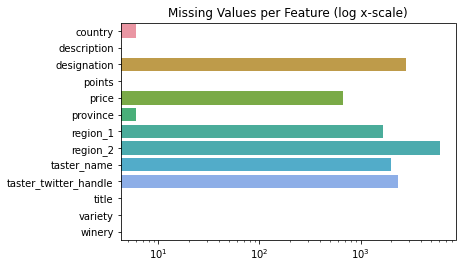

In [65]:
def nan_info(data:pd.DataFrame, columns_name:str) -> int:
    nan_count = len(data[data[columns_name].isna()])
    print(f"{columns_name} NaN: {nan_count}")
    print(f"Equal to {(nan_count/len(data))*100}%")
    print("-"*20)
    return nan_count

print(f"Example count {len(wine)}")

nan_counts = []

for col in wine.columns:
    nan_counts.append(nan_info(wine, col))

ax = sns.barplot(y = wine.columns, x  = nan_counts)
ax.set_title("Missing Values per Feature (log x-scale)")
ax.set_xscale("log")

In [216]:
# Designation has to many missing values, thus is not suiteable for a prediction
# Same for region_1 and region_2
# The title will also be neglected, as it is hard to draw any correlations from it, since it is individual for each wine
wine[(wine["taster_name"].isna()) & (~wine["taster_twitter_handle"].isna())]

'99.3% of wine have a unique name'

#### Filling missing Taster names

In [40]:
# See if taster name can be filled by using the corresponding twitter handle
# They can not, sadly
wine[(wine["taster_name"].isna()) & (~wine["taster_twitter_handle"].isna())]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


#### Fill missing prices

Text(0.5, 1.0, 'Missing Prices per Country')

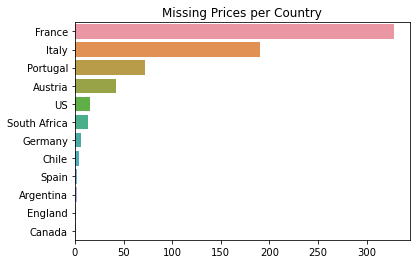

In [95]:
## The plan is to fill the prices by the countries price average
## Investigating the countries of the missing prices
price_to_country = wine[wine["price"].isna()].country.value_counts()

ax = sns.barplot(y = price_to_country.index, x  = price_to_country.values)
ax.set_title("Missing Prices per Country")

In [222]:
wine[wine["price"].isna()].country.unique()

array(['Italy', 'France', 'Austria', 'US', 'Chile', 'Portugal', 'Germany',
       'Canada', 'South Africa', 'Spain', 'Argentina', nan, 'England'],
      dtype=object)

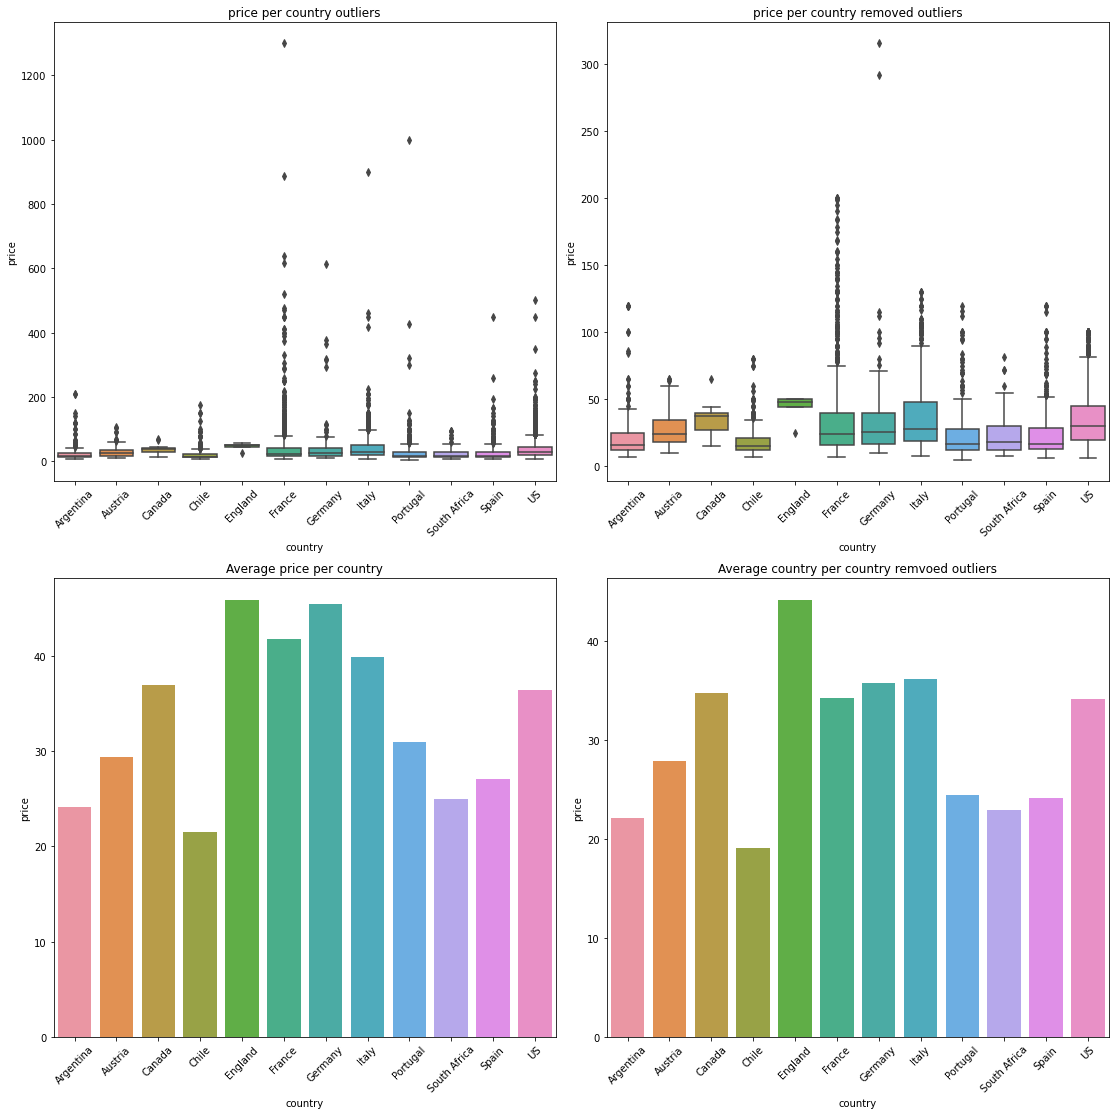

In [228]:
## Removing outliers
def outlieres_per_categorie(data:pd.DataFrame, categorie:str, outlieres:str, quantile_cutoff = 0.99):

    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(len(data[categorie].unique())*1.3, 
                                                           len(data[categorie].unique())*1.3))
    data = data.sort_values(by = categorie)
    ax = sns.boxplot(x = data[categorie], y = data.price, ax = axs[0][0])
    ax.set_xticklabels(labels = data[categorie].unique(), rotation = 45)
    ax.set_title(f"{outlieres} per {categorie} outliers")

    average_price = data.groupby(categorie).mean()

    ax = sns.barplot(x = average_price.index, y = average_price[outlieres], ax = axs[1][0])
    ax.set_xticklabels(labels = data[categorie].unique(), rotation = 45)
    ax.set_title(f"Average {outlieres} per {categorie}")

    for cat in data[categorie].unique():
        quantile = data[data[categorie] == cat].price.quantile(quantile_cutoff)
        data = data[~((data[categorie] == cat) & (data[outlieres] > quantile))]

    ax = sns.boxplot(x = data[categorie], y = data.price, ax = axs[0][1])
    ax.set_xticklabels(labels = data[categorie].unique(), rotation = 45)
    ax.set_title(f"{outlieres} per {categorie} removed outliers")

    average_price = data.groupby(categorie).mean()
    
    ax = sns.barplot(x = average_price.index, y = average_price[outlieres], ax = axs[1][1])
    ax.set_xticklabels(labels = data[categorie].unique(), rotation = 45)
    ax.set_title(f"Average {categorie} per {categorie} remvoed outliers")

    fig.tight_layout()
    
    return axs, average_price

country_slice = wine[wine["country"].isin(wine[wine["price"].isna()].country.unique())].dropna(subset = ["country"])

axs, price_average = outlieres_per_categorie(country_slice, "country", "price", quantile_cutoff = 0.98)

### Categorical Features

In [207]:
## Checking the count of categorical features
## To decide on encoding method#
## Neglecting twitter_handel, as it should hold the same information like the taster name. 
## Taster Name, however, is not missing as many value
print(f"variety: {len(wine['variety'].unique())}")
print(f"country: {len(wine['country'].unique())}")
print(f"province: {len(wine['province'].unique())}")
print(f"winery: {len(wine['winery'].unique())}")
print(f"taster_name: {len(wine['taster_name'].unique())}")

variety: 333
country: 38
province: 249
winery: 5460
taster_name: 19


In [174]:
wine["country"].unique()

array(['Italy', 'France', 'US', 'South Africa', 'Australia', 'Argentina',
       'Germany', 'Austria', 'New Zealand', 'Chile', 'Spain', 'Portugal',
       'Canada', 'Hungary', 'England', 'Slovenia', 'Israel', 'Bulgaria',
       'Turkey', 'Romania', 'Mexico', 'Greece', 'Serbia', 'Uruguay', nan,
       'Croatia', 'Lebanon', 'Georgia', 'Brazil', 'India', 'Moldova',
       'Czech Republic', 'Switzerland', 'Peru', 'Morocco', 'Armenia',
       'Macedonia', 'Cyprus'], dtype=object)

In [217]:
wine[wine["country"].isna()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1511,NaN,"Amber to the eye, this wine features an entici...",Dry Unfiltered Rkatsiteli Mtsvane,88,25.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,Gotsa Family Wines 2015 Dry Unfiltered Rkatsit...,White Blend,Gotsa Family Wines
5239,NaN,Made from 100% Melnick this garnet-colored win...,Nobile,88,23.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,Logodaj 2013 Nobile Melnik,Melnik,Logodaj
5648,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Roger Voss,@vossroger,Barton & Guestier NV Partager Red,Red Blend,Barton & Guestier
5667,NaN,This wine is made from grapes grown in the Lak...,Márga,89,18.0,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,St. Donat 2015 Márga Furmint,Furmint,St. Donat
7333,NaN,Basic cherry aromas turn more earthy and soupy...,Reserva Estate Bottled,85,12.0,NaN,NaN,NaN,Michael Schachner,@wineschach,Chilcas 2015 Reserva Estate Bottled Pinot Noir,Pinot Noir,Chilcas
7917,NaN,"Almost caramel in color, this wine offers arom...",Babaneuri Valley,87,30.0,NaN,NaN,NaN,Mike DeSimone,@worldwineguys,Gotsa Family Wines 2013 Babaneuri Valley Mtsvane,Mtsvane,Gotsa Family Wines


9930